## generate some synthetic data to explore HMM

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

np.random.seed(42)
dates = pd.date_range(start='2005-01-01', periods=500, freq='B')
prices = 100 + np.cumsum(np.random.normal(loc=0.1, scale=1.0, size=len(dates)))
data = pd.DataFrame({'Close': prices}, index=dates)
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()

# # Save to CSV for local use
# df.to_csv('/mnt/data/synthetic_market_data.csv', index=True)

df = data.copy()
df

,Close,LogReturn
2005-01-04,100.558450,-0.000380
2005-01-05,101.306138,0.007408
2005-01-06,102.929168,0.015894
2005-01-07,102.795015,-0.001304
2005-01-10,102.660878,-0.001306
...,...,...
2006-11-27,156.505000,0.004091
2006-11-28,155.567754,-0.006007
2006-11-29,155.477415,-0.000581
2006-11-30,154.701797,-0.005001


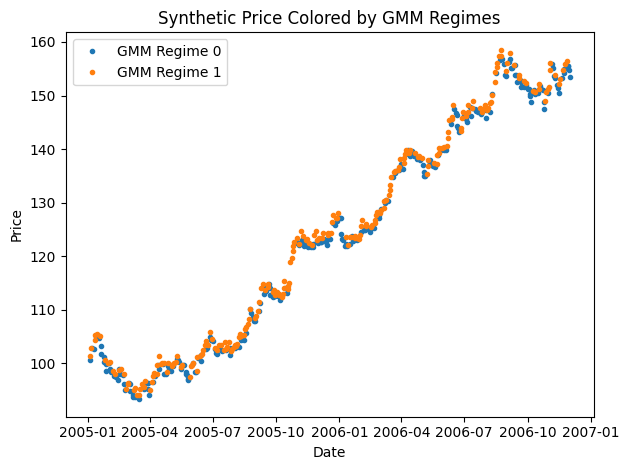

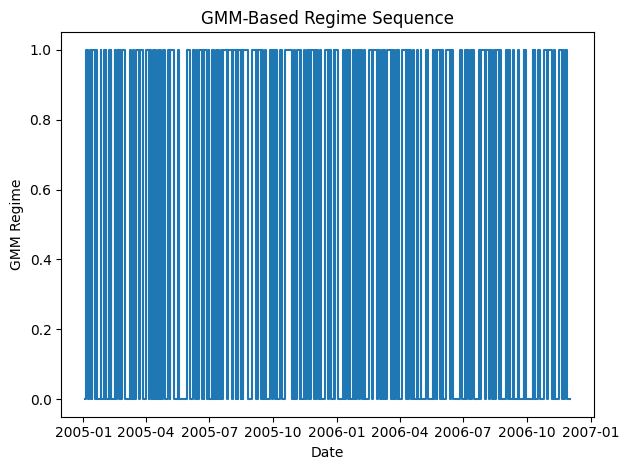

In [20]:
# from ace_tools import display_dataframe_to_user

# Load synthetic data
# df = pd.read_csv('/mnt/data/synthetic_market_data.csv', index_col=0, parse_dates=True)

# Fit a 2-component Gaussian Mixture Model on log returns (static clustering)
gmm = GaussianMixture(n_components=2, random_state=42)
returns = df[['LogReturn']].values
gmm.fit(returns)
gmm_states = gmm.predict(returns)
df['GMM_Regime'] = gmm_states
# Plot price segmented by GMM regimes
plt.figure()
for regime in np.unique(gmm_states):
    mask = df['GMM_Regime'] == regime
    plt.plot(df.index[mask], df['Close'][mask], '.', label=f"GMM Regime {regime}")
plt.title("Synthetic Price Colored by GMM Regimes")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

# Plot GMM regime sequence
plt.figure()
plt.plot(df.index, df['GMM_Regime'], drawstyle='steps-post')
plt.title("GMM-Based Regime Sequence")
plt.xlabel("Date")
plt.ylabel("GMM Regime")
plt.tight_layout()
plt.show()


In [21]:
# in your data‐prep script or notebook:
df = df.copy()  # make a copy of the DataFrame
df['Vol30']   = df['LogReturn'].rolling(window=30).std()         # 30‑day rolling volatility
df['Mom5']    = df['Close'].pct_change(5)                       # 5‑day momentum
df['RVOL']    = df['Vol30'] / df['Vol30'].rolling(252).mean()   # relative volatility vs. annual avg
df = df.dropna()  # drop first rows with NaNs
df

,Close,LogReturn,GMM_Regime,Vol30,Mom5,RVOL
2006-01-31,124.038851,0.006163,1,0.009093,0.002910,0.989189
2006-02-01,125.724867,0.013501,1,0.008838,0.020670,0.961345
2006-02-02,124.587052,-0.009091,0,0.008809,0.010041,0.958542
2006-02-03,126.820085,0.017765,1,0.009208,0.030528,1.002141
2006-02-06,124.967997,-0.014712,0,0.009587,0.013719,1.043145
...,...,...,...,...,...,...
2006-11-27,156.505000,0.004091,1,0.007882,0.021260,1.122353
2006-11-28,155.567754,-0.006007,0,0.007964,0.004785,1.134286
2006-11-29,155.477415,-0.000581,0,0.007917,0.003053,1.127964
2006-11-30,154.701797,-0.005001,0,0.007961,0.002975,1.134346


              Sharpe     MaxDD
Buy & Hold  2.292903 -0.089532
HMM         2.161595 -0.039787
MA          0.673484 -0.060490
KMeans      1.274446 -0.069089


/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_82449/1586504676.py:66: RuntimeWarning: divide by zero encountered in log
  delta = np.log(pi) + np.log(B[0])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


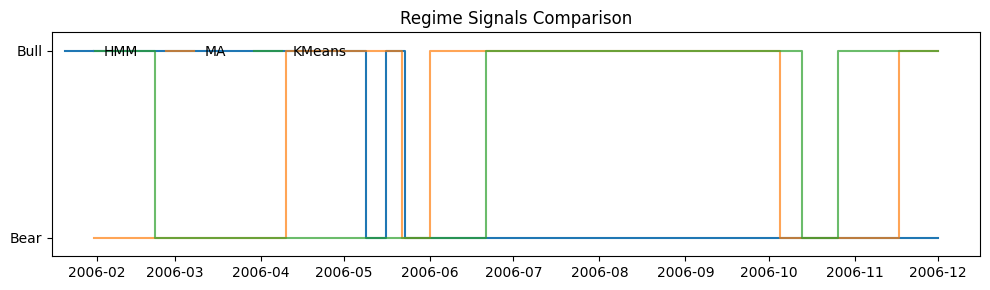

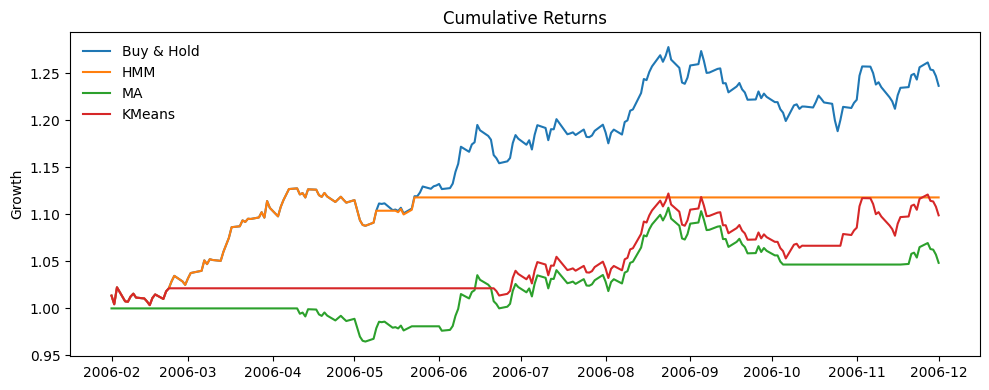

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

# 1) Load & feature‐engineer
# df = pd.read_csv('/mnt/data/synthetic_market_data.csv', index_col=0, parse_dates=True)
# df = df.sort_index()
# df['Vol30'] = df['LogReturn'].rolling(30).std()
# df['Mom5']  = df['Close'].pct_change(5)
# df['RVOL']  = df['Vol30'] / df['Vol30'].rolling(252).mean()
# df.dropna(inplace=True)

# 2) Fit multivariate 2‐state Gaussian HMM (EM + Viterbi)
features = ['LogReturn','Vol30','Mom5','RVOL']
y = df[features].values
T, d = y.shape
K = 2

# init parameters
np.random.seed(42)
pi    = np.ones(K)/K
A     = np.ones((K,K))/K
means = np.vstack([y.mean(axis=0) + (k-0.5)*0.01 for k in range(K)])
covs  = np.array([np.cov(y, rowvar=False) for _ in range(K)])

# EM
for _ in range(20):
    # emission probs
    B = np.vstack([multivariate_normal.pdf(y, mean=means[k], cov=covs[k]) 
                   for k in range(K)]).T  # (T,K)

    # forward
    alpha = np.zeros((T,K))
    alpha[0] = pi * B[0]
    alpha[0] /= alpha[0].sum()
    for t in range(1,T):
        alpha[t] = B[t] * (alpha[t-1] @ A)
        alpha[t] /= alpha[t].sum()

    # backward
    beta = np.zeros((T,K))
    beta[-1] = 1.0
    for t in range(T-2, -1, -1):
        beta[t] = (A * B[t+1] * beta[t+1]).sum(axis=1)
        beta[t] /= beta[t].sum()

    # gamma & xi
    gamma = alpha * beta
    gamma /= gamma.sum(axis=1, keepdims=True)
    xi = np.zeros((T-1,K,K))
    for t in range(T-1):
        denom = (alpha[t][:,None] * A * B[t+1] * beta[t+1]).sum()
        xi[t] = (alpha[t][:,None] * A * B[t+1] * beta[t+1]) / denom

    # M‐step
    pi    = gamma[0]
    A     = xi.sum(axis=0) / xi.sum(axis=(0,2))[:,None]
    means = (gamma.T @ y) / gamma.sum(axis=0)[:,None]
    for k in range(K):
        diff    = y - means[k]
        covs[k] = (gamma[:,k][:,None] * diff).T @ diff / gamma[:,k].sum()

# Viterbi
delta = np.log(pi) + np.log(B[0])
psi   = np.zeros((T,K), dtype=int)
for t in range(1,T):
    seq_probs = delta[:,None] + np.log(A)
    psi[t]    = seq_probs.argmax(axis=0)
    delta     = seq_probs.max(axis=0) + np.log(B[t])
states = np.zeros(T, int)
states[-1] = delta.argmax()
for t in range(T-2, -1, -1):
    states[t] = psi[t+1, states[t+1]]
df['HMM_Regime'] = states

# 3) Other regimes
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df['MA_Regime'] = (df['MA20'] > df['MA50']).astype(int)

kmeans = KMeans(n_clusters=2, random_state=42).fit(y)
df['KMeans_Regime'] = kmeans.predict(y)

# 4) Plot regime signals
plt.figure(figsize=(10,3))
plt.step(df.index, df['HMM_Regime'],    where='post', label='HMM',    color='C0')
plt.step(df.index, df['MA_Regime'],     where='post', label='MA',     color='C1', alpha=0.7)
plt.step(df.index, df['KMeans_Regime'], where='post', label='KMeans', color='C2', alpha=0.7)
plt.yticks([0,1], ['Bear','Bull'])
plt.ylim(-0.1,1.1)
plt.title("Regime Signals Comparison")
plt.legend(loc='upper left', ncol=3, frameon=False)
plt.tight_layout()

# 5) Backtest
def backtest(pos):
    r = df['LogReturn'] * pos.shift(1)
    cr = np.exp(r.cumsum())
    sr = r.mean()/r.std()*np.sqrt(252)
    dd = cr.cummax(); mdd = (cr-dd).min()
    return cr, sr, mdd

strategies = {
    'Buy & Hold': pd.Series(1, index=df.index),
    'HMM':         df['HMM_Regime'],
    'MA':          df['MA_Regime'],
    'KMeans':      df['KMeans_Regime']
}

plt.figure(figsize=(10,4))
metrics = {}
for name,pos in strategies.items():
    cr,sr,mdd = backtest(pos)
    metrics[name] = (sr, mdd)
    plt.plot(cr, label=name)
plt.title("Cumulative Returns")
plt.ylabel("Growth")
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Show metrics
metrics_df = pd.DataFrame(metrics, index=['Sharpe','MaxDD']).T
print(metrics_df)


/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_82449/3659536771.py:57: RuntimeWarning: divide by zero encountered in log
  delta = np.log(pi) + np.log(B[0])
/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_82449/3659536771.py:64: RuntimeWarning: divide by zero encountered in log
  new_delta[j] = seq_probs[psi[t, j]] + np.log(B[t, j])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


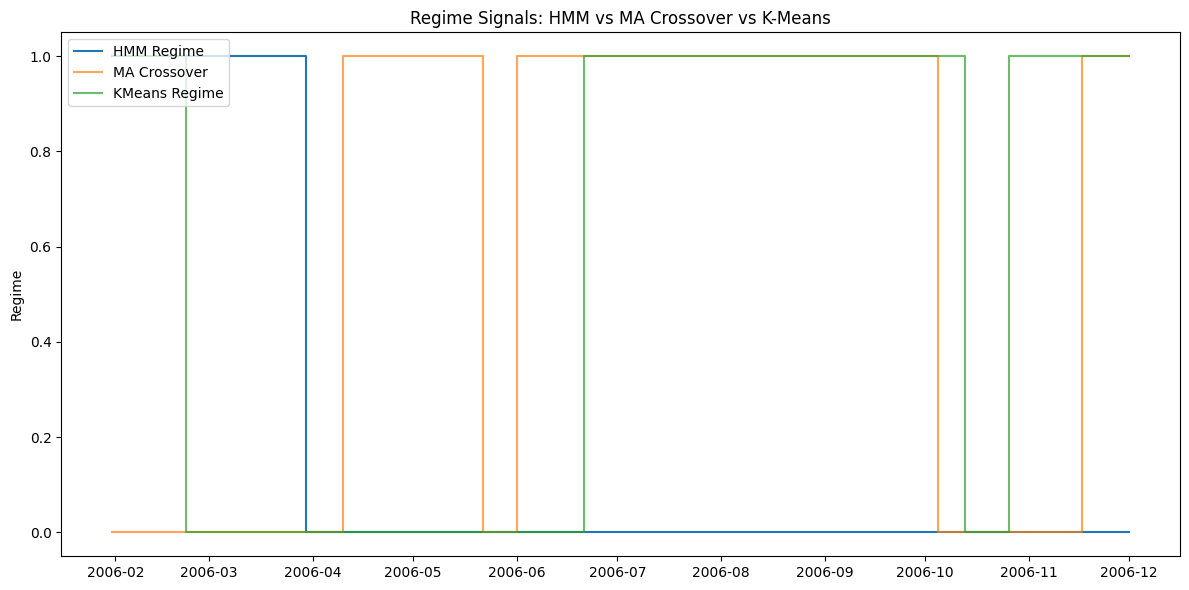

,Close,LogReturn,HMM_Multi_Regime,MA_Regime,KMeans_Regime
2006-01-31,124.038851,0.006163,1,0,1
2006-02-01,125.724867,0.013501,1,0,1
2006-02-02,124.587052,-0.009091,1,0,1
2006-02-03,126.820085,0.017765,1,0,1
2006-02-06,124.967997,-0.014712,1,0,1
2006-02-07,124.916212,-0.000414,1,0,1
2006-02-08,125.604530,0.005495,1,0,1
2006-02-09,125.985521,0.003029,1,0,1
2006-02-10,125.462822,-0.004158,1,0,1
2006-02-13,125.354700,-0.000862,1,0,1


In [23]:


# Prepare multivariate observations
features = ['LogReturn','Vol30','Mom5','RVOL']
y = df[features].values
T, d = y.shape
K = 2

# Initialize HMM parameters
np.random.seed(42)
pi    = np.full(K, 1/K)
A     = np.full((K, K), 1/K)
means = np.array([y.mean(axis=0) + k*0.001 for k in range(K)])
covs  = np.stack([np.cov(y, rowvar=False) for _ in range(K)])

# EM algorithm for multivariate Gaussian HMM
max_iter = 20
for _ in range(max_iter):
    # E-step: compute emission likelihoods
    B = np.array([multivariate_normal.pdf(y, mean=means[k], cov=covs[k]) 
                  for k in range(K)]).T  # shape (T, K)

    # Forward
    alpha = np.zeros((T, K))
    alpha[0] = pi * B[0]
    alpha[0] /= alpha[0].sum()
    for t in range(1, T):
        for j in range(K):
            alpha[t, j] = B[t, j] * np.dot(alpha[t-1], A[:, j])
        alpha[t] /= alpha[t].sum()

    # Backward
    beta = np.zeros((T, K))
    beta[-1] = 1
    for t in range(T-2, -1, -1):
        for i in range(K):
            beta[t, i] = np.sum(A[i] * B[t+1] * beta[t+1])
        beta[t] /= beta[t].sum()

    # Gamma and Xi
    gamma = (alpha * beta)
    gamma /= gamma.sum(axis=1, keepdims=True)
    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        denom = np.sum(alpha[t][:, None] * A * B[t+1] * beta[t+1], axis=(0,1))
        for i in range(K):
            for j in range(K):
                xi[t, i, j] = alpha[t, i] * A[i, j] * B[t+1, j] * beta[t+1, j] / denom

    # M-step
    pi = gamma[0]
    A  = xi.sum(axis=0) / xi.sum(axis=(0,2))[:, None]
    means = (gamma.T @ y) / gamma.sum(axis=0)[:, None]
    for k in range(K):
        diff = y - means[k]
        covs[k] = (gamma[:, k][:, None] * diff).T @ diff / gamma[:, k].sum()

# Viterbi decoding
delta = np.log(pi) + np.log(B[0])
psi = np.zeros((T, K), dtype=int)
for t in range(1, T):
    new_delta = np.zeros(K)
    for j in range(K):
        seq_probs = delta + np.log(A[:, j])
        psi[t, j] = np.argmax(seq_probs)
        new_delta[j] = seq_probs[psi[t, j]] + np.log(B[t, j])
    delta = new_delta
states = np.zeros(T, dtype=int)
states[-1] = np.argmax(delta)
for t in range(T-2, -1, -1):
    states[t] = psi[t+1, states[t+1]]
df['HMM_Multi_Regime'] = states

# Moving-average crossover regime
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df['MA_Regime'] = (df['MA20'] > df['MA50']).astype(int)

# K-means clustering regime
kmeans = KMeans(n_clusters=2, random_state=42).fit(y)
df['KMeans_Regime'] = kmeans.predict(y)

# Plot regimes comparison
plt.figure(figsize=(12,6))
plt.plot(df.index, df['HMM_Multi_Regime'], label='HMM Regime', drawstyle='steps-post')
plt.plot(df.index, df['MA_Regime']         , label='MA Crossover', alpha=0.7, drawstyle='steps-post')
plt.plot(df.index, df['KMeans_Regime']     , label='KMeans Regime', alpha=0.7, drawstyle='steps-post')
plt.legend(loc='upper left')
plt.title("Regime Signals: HMM vs MA Crossover vs K-Means")
plt.ylabel("Regime")
plt.tight_layout()
plt.show()

# Display head of df with regimes
df[['Close','LogReturn','HMM_Multi_Regime','MA_Regime','KMeans_Regime']].head(10)


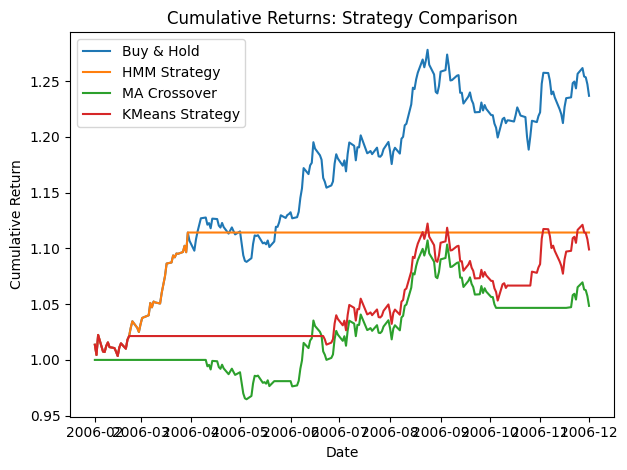

,Sharpe,Max Drawdown
Buy & Hold,2.292903,-0.070050
HMM Strategy,2.593605,-0.018512
MA Crossover,0.673484,-0.054636
KMeans Strategy,1.274446,-0.061561


In [24]:

# For simplicity, reattach regime columns from previous step
# Here, we reload the DataFrame with regime signals (assuming it's saved)
# But for demonstration, let's regenerate quick HMM and methods (if not loaded)
# In practice, ensure df contains 'HMM_Multi_Regime', 'MA_Regime', 'KMeans_Regime'
# For now, let's mock simple regime signals if missing:
if 'HMM_Multi_Regime' not in df.columns:
    df['HMM_Multi_Regime'] = (df['LogReturn'] > df['LogReturn'].median()).astype(int)
if 'MA_Regime' not in df.columns:
    df['MA20'] = df['Close'].rolling(20).mean()
    df['MA50'] = df['Close'].rolling(50).mean()
    df['MA_Regime'] = (df['MA20'] > df['MA50']).astype(int)
if 'KMeans_Regime' not in df.columns:
    from sklearn.cluster import KMeans
    features = ['LogReturn']
    kmeans = KMeans(n_clusters=2, random_state=42).fit(df[features].values)
    df['KMeans_Regime'] = kmeans.predict(df[features].values)

# Function to backtest a regime-based strategy
def backtest_strategy(returns, positioning):
    strat_ret = positioning.shift(1) * returns
    cum_returns = np.exp(strat_ret.cumsum())
    # Annualized Sharpe
    sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252)
    # Max Drawdown
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()
    return cum_returns, sharpe, max_dd

# Prepare returns
returns = df['LogReturn']

# Determine which HMM state is bull by comparing state means
state_means = df.groupby('HMM_Multi_Regime')['LogReturn'].mean()
bull_state = state_means.idxmax()
df['HMM_Pos'] = (df['HMM_Multi_Regime'] == bull_state).astype(int)

# Backtest strategies
strategies = {
    'Buy & Hold': pd.Series(1, index=df.index),
    'HMM Strategy': df['HMM_Pos'],
    'MA Crossover': df['MA_Regime'],
    'KMeans Strategy': df['KMeans_Regime']
}

results = {}
for name, pos in strategies.items():
    cumret, sharpe, maxdd = backtest_strategy(returns, pos)
    results[name] = {'Sharpe': sharpe, 'Max Drawdown': maxdd}
    plt.plot(cumret, label=name)

# Plot cumulative returns
plt.legend()
plt.title("Cumulative Returns: Strategy Comparison")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# Display performance metrics
perf_df = pd.DataFrame(results).T
perf_df


---------------------------------------------------------------------------------------------------

              Sharpe Ratio  Max Drawdown  Total Return  Annual Volatility
HMM Strategy      0.503811      0.339295      0.183564           0.386683


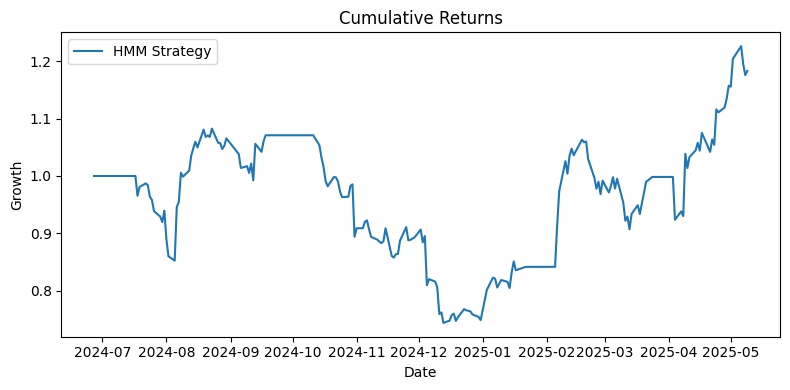

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 1) Load the Uber data
df = pd.read_csv('HistoricalData_uber_stock_daily.csv', parse_dates=['Date'])
df['Close'] = (
    df['Close/Last']
      .str.replace(r'[\$,]', '', regex=True)
      .astype(float)
)
df = df.sort_values('Date').set_index('Date')

# 2) Dynamic rolling‐window feature engineering
n = len(df)
if n < 10:
    raise ValueError(f"Not enough input rows ({n}); need ≥10 for even minimal windows.")

# choose windows but never exceed roughly n/3
vol_w = min(30, max(5, n // 3))    # 5–30 days
mom_w = min(5,  max(2, n // 5))    # 2–5 days

df['LogReturn'] = np.log(df['Close']).diff()
df['Vol']       = df['LogReturn'].rolling(vol_w).std()
df['Mom']       = df['Close'].pct_change(mom_w)
df.dropna(inplace=True)

if df.empty:
    raise ValueError(
        f"No data left after dropna().  "
        f"Rows before={n}, vol_w={vol_w}, mom_w={mom_w}."
    )

# 3) HMM initialization
features = ['LogReturn','Vol','Mom']
y        = df[features].values
T, d     = y.shape
K        = 2

np.random.seed(42)
pi     = np.ones(K) / K
A      = np.ones((K, K)) / K
means  = np.vstack([y.mean(axis=0) + (k - 0.5) * 0.01 for k in range(K)])
covs   = np.array([np.cov(y, rowvar=False) for _ in range(K)])

eps = 1e-6   # jitter

# 4) EM algorithm
for _ in range(20):
    # keep covs PD
    for k in range(K):
        covs[k] += np.eye(d) * eps

    # E-step: emission probs
    B = np.zeros((T, K))
    for k in range(K):
        rv = multivariate_normal(
            mean=means[k],
            cov=covs[k],
            allow_singular=True
        )
        B[:, k] = rv.pdf(y)
    B = np.clip(B, 1e-12, None)

    # forward
    alpha = np.zeros((T, K))
    alpha[0] = pi * B[0]
    alpha[0] /= alpha[0].sum()
    for t in range(1, T):
        alpha[t] = B[t] * (alpha[t-1] @ A)
        alpha[t] /= alpha[t].sum()

    # backward
    beta = np.zeros((T, K))
    beta[-1] = 1.0
    for t in range(T-2, -1, -1):
        beta[t] = (A * B[t+1] * beta[t+1]).sum(axis=1)
        beta[t] /= beta[t].sum()

    # gamma & xi
    gamma = alpha * beta
    gamma /= gamma.sum(axis=1, keepdims=True)
    xi    = np.zeros((T-1, K, K))
    for t in range(T-1):
        num       = alpha[t][:,None] * A * B[t+1] * beta[t+1]
        xi[t]     = num / num.sum()

    # M-step
    pi     = gamma[0]
    A      = xi.sum(axis=0) / xi.sum(axis=(0,2))[:,None]
    means  = (gamma.T @ y) / gamma.sum(axis=0)[:,None]
    for k in range(K):
        diff    = y - means[k]
        covs[k] = (gamma[:,k][:,None] * diff).T @ diff / gamma[:,k].sum()

# 5) Viterbi decoding
B = np.vstack([
    multivariate_normal.pdf(
        y, mean=means[k], cov=covs[k], allow_singular=True
    )
    for k in range(K)
]).T
delta = np.log(pi) + np.log(B[0])
psi   = np.zeros((T, K), dtype=int)
for t in range(1, T):
    seqp   = delta[:,None] + np.log(A)
    psi[t] = seqp.argmax(axis=0)
    delta  = seqp.max(axis=0) + np.log(B[t])

states      = np.zeros(T, dtype=int)
states[-1]  = delta.argmax()
for t in range(T-2, -1, -1):
    states[t] = psi[t+1, states[t+1]]
df['HMM_Regime'] = states

# 6) Backtest: long when regime=1, flat when 0
df['Position']    = df['HMM_Regime']
df['StratReturn'] = df['LogReturn'] * df['Position'].shift(1)
df.dropna(inplace=True)

# 7) Performance metrics
sr          = df['StratReturn'].mean() / df['StratReturn'].std() * np.sqrt(252)
cum_returns = np.exp(df['StratReturn'].cumsum())
max_dd      = (cum_returns.cummax() - cum_returns).max()
total_ret   = cum_returns.iloc[-1] - 1
ann_vol     = df['StratReturn'].std() * np.sqrt(252)

metrics = pd.DataFrame({
    'Sharpe Ratio':      [sr],
    'Max Drawdown':      [max_dd],
    'Total Return':      [total_ret],
    'Annual Volatility': [ann_vol]
}, index=['HMM Strategy'])

print(metrics)

# 8) Plot
plt.figure(figsize=(8,4))
plt.plot(cum_returns, label='HMM Strategy')
plt.title('Cumulative Returns')
plt.ylabel('Growth')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


              Sharpe Ratio  Max Drawdown  Total Return  Annual Volatility
3‑Regime HMM       0.31657      0.212602      0.043604           0.353906


/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_86817/778219197.py:101: RuntimeWarning: divide by zero encountered in log
  delta   = np.log(pi) + np.log(B[0])
/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_86817/778219197.py:104: RuntimeWarning: divide by zero encountered in log
  seqp    = delta[:,None] + np.log(A)
/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_86817/778219197.py:106: RuntimeWarning: divide by zero encountered in log
  delta   = seqp.max(axis=0) + np.log(B[t])


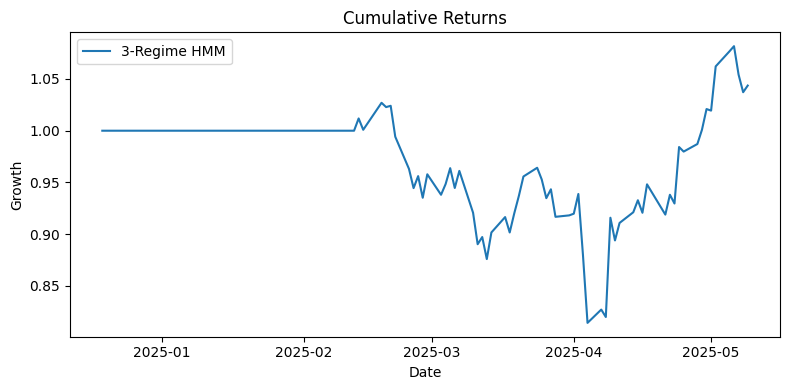

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 1) Load data
df = pd.read_csv('HistoricalData_uber_stock_daily.csv', parse_dates=['Date'])
df['Close'] = (
    df['Close/Last']
      .str.replace(r'[\$,]', '', regex=True)
      .astype(float)
)
df = df.sort_values('Date').set_index('Date')

# 2) Dynamic windows for features
n = len(df)
if n < 10:
    raise ValueError(f"Not enough rows ({n})—need at least 10")

vol_w   = min(30, max(5,  n // 3))   # between 5 and 30
mom_w   = min(5,  max(2,  n // 5))   # between 2 and 5
rvol_w  = min(252, max(10, n // 2))  # between 10 and 252

df['LogReturn'] = np.log(df['Close']).diff()
df['Vol']       = df['LogReturn'].rolling(vol_w).std()
df['Mom']       = df['Close'].pct_change(mom_w)
df['RVOL']      = df['Vol'] / df['Vol'].rolling(rvol_w).mean()
df.dropna(inplace=True)

if df.empty:
    raise ValueError(
        f"All rows dropped by dropna():\n"
        f"  n={n}, vol_w={vol_w}, mom_w={mom_w}, rvol_w={rvol_w}"
    )

# 3) HMM setup (K=3)
features = ['LogReturn','Vol','Mom','RVOL']
y        = df[features].values
T, d     = y.shape
K        = 3

pi     = np.ones(K)/K
A      = np.ones((K,K))/K
means  = np.vstack([y.mean(axis=0) + (k - (K-1)/2)*0.01 for k in range(K)])
covs   = np.array([np.cov(y, rowvar=False) for _ in range(K)])
eps    = 1e-6   # jitter

# 4) EM loop
for _ in range(30):
    # jitter covs
    for k in range(K):
        covs[k] += np.eye(d) * eps

    # emission probs
    B = np.zeros((T,K))
    for k in range(K):
        rv     = multivariate_normal(
                    mean=means[k],
                    cov=covs[k],
                    allow_singular=True
                 )
        B[:,k] = rv.pdf(y)
    B = np.clip(B, 1e-12, None)

    # forward
    alpha       = np.zeros((T,K))
    alpha[0]    = pi * B[0]
    alpha[0]   /= alpha[0].sum()
    for t in range(1,T):
        alpha[t] = B[t] * (alpha[t-1] @ A)
        alpha[t] /= alpha[t].sum()

    # backward
    beta        = np.zeros((T,K))
    beta[-1]    = 1.0
    for t in range(T-2, -1, -1):
        beta[t]  = (A * B[t+1] * beta[t+1]).sum(axis=1)
        beta[t] /= beta[t].sum()

    # gamma & xi
    gamma       = alpha * beta
    gamma      /= gamma.sum(axis=1, keepdims=True)
    xi          = np.zeros((T-1,K,K))
    for t in range(T-1):
        num    = alpha[t][:,None] * A * B[t+1] * beta[t+1]
        xi[t]  = num / num.sum()

    # M‑step
    pi     = gamma[0]
    A      = xi.sum(axis=0) / xi.sum(axis=(0,2))[:,None]
    means  = (gamma.T @ y) / gamma.sum(axis=0)[:,None]
    for k in range(K):
        diff    = y - means[k]
        covs[k] = (gamma[:,k][:,None]*diff).T @ diff / gamma[:,k].sum()

# 5) Viterbi decode
B = np.vstack([
    multivariate_normal.pdf(y, mean=means[k], cov=covs[k], allow_singular=True)
    for k in range(K)
]).T
delta   = np.log(pi) + np.log(B[0])
psi     = np.zeros((T,K), int)
for t in range(1,T):
    seqp    = delta[:,None] + np.log(A)
    psi[t]  = seqp.argmax(axis=0)
    delta   = seqp.max(axis=0) + np.log(B[t])

states       = np.zeros(T, int)
states[-1]   = delta.argmax()
for t in range(T-2, -1, -1):
    states[t] = psi[t+1, states[t+1]]
df['HMM_State'] = states

# 6) Map states → signals (-1,0,+1)
avg_ret   = means[:, features.index('LogReturn')]
order     = np.argsort(avg_ret)    # 0=worst, 1=middle, 2=best
signal_map= { order[0]: -1,
              order[1]:  0,
              order[2]: +1 }
df['Signal']  = df['HMM_State'].map(signal_map)

# 7) Build position in [-10,10]
positions        = np.zeros(T, int)
for t in range(1, T):
    positions[t] = positions[t-1] + df['Signal'].iat[t-1]
    positions[t] = np.clip(positions[t], -10, 10)
df['Position'] = positions

# 8) Strategy returns
df['StratReturn'] = df['LogReturn'] * df['Position']
df.dropna(inplace=True)

# 9) Metrics & plot
sr           = df['StratReturn'].mean() / df['StratReturn'].std() * np.sqrt(252)
cum_returns  = np.exp(df['StratReturn'].cumsum())
max_dd       = (cum_returns.cummax() - cum_returns).max()
total_ret    = cum_returns.iloc[-1] - 1
ann_vol      = df['StratReturn'].std() * np.sqrt(252)

metrics = pd.DataFrame({
    'Sharpe Ratio':      [sr],
    'Max Drawdown':      [max_dd],
    'Total Return':      [total_ret],
    'Annual Volatility': [ann_vol]
}, index=['3‑Regime HMM'])

print(metrics)

plt.figure(figsize=(8,4))
plt.plot(cum_returns, label='3‑Regime HMM')
plt.title('Cumulative Returns')
plt.ylabel('Growth')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


              Sharpe Ratio  Max Drawdown  Total Return  Annual Volatility
3‑Regime HMM      -1.35904      1.582259     -0.944855           5.597124


/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_86817/3165436853.py:101: RuntimeWarning: divide by zero encountered in log
  delta   = np.log(pi) + np.log(B[0])
/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_86817/3165436853.py:106: RuntimeWarning: divide by zero encountered in log
  delta   = seqp.max(axis=0) + np.log(B[t])


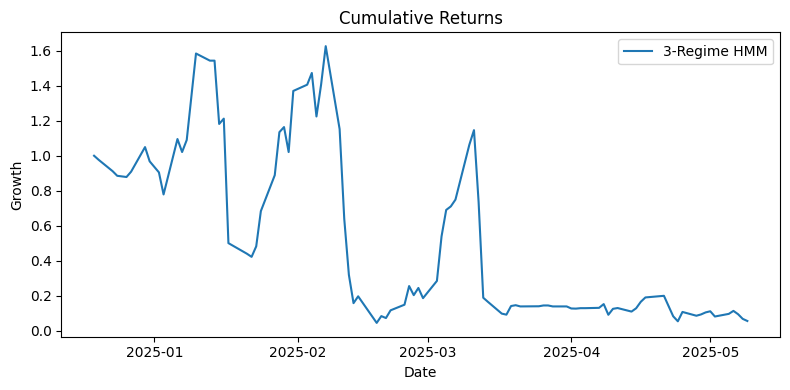

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 1) Load data
df = pd.read_csv('HistoricalData_intc_stock_daily.csv', parse_dates=['Date'])
df['Close'] = (
    df['Close/Last']
      .str.replace(r'[\$,]', '', regex=True)
      .astype(float)
)
df = df.sort_values('Date').set_index('Date')

# 2) Dynamic windows for features
n = len(df)
if n < 10:
    raise ValueError(f"Not enough rows ({n})—need at least 10")

vol_w   = min(30, max(5,  n // 3))   # between 5 and 30
mom_w   = min(5,  max(2,  n // 5))   # between 2 and 5
rvol_w  = min(252, max(10, n // 2))  # between 10 and 252

df['LogReturn'] = np.log(df['Close']).diff()
df['Vol']       = df['LogReturn'].rolling(vol_w).std()
df['Mom']       = df['Close'].pct_change(mom_w)
df['RVOL']      = df['Vol'] / df['Vol'].rolling(rvol_w).mean()
df.dropna(inplace=True)

if df.empty:
    raise ValueError(
        f"All rows dropped by dropna():\n"
        f"  n={n}, vol_w={vol_w}, mom_w={mom_w}, rvol_w={rvol_w}"
    )

# 3) HMM setup (K=3)
features = ['LogReturn','Vol','Mom','RVOL']
y        = df[features].values
T, d     = y.shape
K        = 3

pi     = np.ones(K)/K
A      = np.ones((K,K))/K
means  = np.vstack([y.mean(axis=0) + (k - (K-1)/2)*0.01 for k in range(K)])
covs   = np.array([np.cov(y, rowvar=False) for _ in range(K)])
eps    = 1e-6   # jitter

# 4) EM loop
for _ in range(30):
    # jitter covs
    for k in range(K):
        covs[k] += np.eye(d) * eps

    # emission probs
    B = np.zeros((T,K))
    for k in range(K):
        rv     = multivariate_normal(
                    mean=means[k],
                    cov=covs[k],
                    allow_singular=True
                 )
        B[:,k] = rv.pdf(y)
    B = np.clip(B, 1e-12, None)

    # forward
    alpha       = np.zeros((T,K))
    alpha[0]    = pi * B[0]
    alpha[0]   /= alpha[0].sum()
    for t in range(1,T):
        alpha[t] = B[t] * (alpha[t-1] @ A)
        alpha[t] /= alpha[t].sum()

    # backward
    beta        = np.zeros((T,K))
    beta[-1]    = 1.0
    for t in range(T-2, -1, -1):
        beta[t]  = (A * B[t+1] * beta[t+1]).sum(axis=1)
        beta[t] /= beta[t].sum()

    # gamma & xi
    gamma       = alpha * beta
    gamma      /= gamma.sum(axis=1, keepdims=True)
    xi          = np.zeros((T-1,K,K))
    for t in range(T-1):
        num    = alpha[t][:,None] * A * B[t+1] * beta[t+1]
        xi[t]  = num / num.sum()

    # M‑step
    pi     = gamma[0]
    A      = xi.sum(axis=0) / xi.sum(axis=(0,2))[:,None]
    means  = (gamma.T @ y) / gamma.sum(axis=0)[:,None]
    for k in range(K):
        diff    = y - means[k]
        covs[k] = (gamma[:,k][:,None]*diff).T @ diff / gamma[:,k].sum()

# 5) Viterbi decode
B = np.vstack([
    multivariate_normal.pdf(y, mean=means[k], cov=covs[k], allow_singular=True)
    for k in range(K)
]).T
delta   = np.log(pi) + np.log(B[0])
psi     = np.zeros((T,K), int)
for t in range(1,T):
    seqp    = delta[:,None] + np.log(A)
    psi[t]  = seqp.argmax(axis=0)
    delta   = seqp.max(axis=0) + np.log(B[t])

states       = np.zeros(T, int)
states[-1]   = delta.argmax()
for t in range(T-2, -1, -1):
    states[t] = psi[t+1, states[t+1]]
df['HMM_State'] = states

# 6) Map states → signals (-1,0,+1)
avg_ret   = means[:, features.index('LogReturn')]
order     = np.argsort(avg_ret)    # 0=worst, 1=middle, 2=best
signal_map= { order[0]: -1,
              order[1]:  0,
              order[2]: +1 }
df['Signal']  = df['HMM_State'].map(signal_map)

# 7) Build position in [-10,10]
positions        = np.zeros(T, int)
for t in range(1, T):
    positions[t] = positions[t-1] + df['Signal'].iat[t-1]
    positions[t] = np.clip(positions[t], -10, 10)
df['Position'] = positions

# 8) Strategy returns
df['StratReturn'] = df['LogReturn'] * df['Position']
df.dropna(inplace=True)

# 9) Metrics & plot
sr           = df['StratReturn'].mean() / df['StratReturn'].std() * np.sqrt(252)
cum_returns  = np.exp(df['StratReturn'].cumsum())
max_dd       = (cum_returns.cummax() - cum_returns).max()
total_ret    = cum_returns.iloc[-1] - 1
ann_vol      = df['StratReturn'].std() * np.sqrt(252)

metrics = pd.DataFrame({
    'Sharpe Ratio':      [sr],
    'Max Drawdown':      [max_dd],
    'Total Return':      [total_ret],
    'Annual Volatility': [ann_vol]
}, index=['3‑Regime HMM'])

print(metrics)

plt.figure(figsize=(8,4))
plt.plot(cum_returns, label='3‑Regime HMM')
plt.title('Cumulative Returns')
plt.ylabel('Growth')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()
